# 参考kernal

https://www.kaggle.com/miteshyadav/comprehensive-eda-with-xgboost-top-10-percentile/notebook

https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

# 1 数据检视

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
# import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from datetime import datetime

train =  pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# 项目数据描述如下：
```
       (1) datetime：代表数据日期，以年-月-日 小时的形式给出。 
       (2) season：数据记录时的季节。1 为春季, 2为夏季,3 为秋季,4 为冬季。 
       (3) hodliday：当日是否为假期。1代表是，0代表不是。 
       (4) workingday：当日是否为工作日，即既不是周末也不是假期。1代表是，0代表不是。 
       (5) weather:当日天气： 
              1: 天气晴朗或者少云/部分有云。 
              2: 有雾和云/风等。 
              3: 小雪/小雨，闪电及多云。 
              4: 大雨/冰雹/闪电和大雾/大雪。 
       (6) temp - 当日摄氏温度。 
       (7) atemp - 当日人们感觉的温度。
       (8) humidity - 当日湿度。 
       (9) windspeed - 风速。 
       (10) casual -非预定自行车的人数 
       (11) registered - 登记预定自信车的人数。 
       (12) count - 总租车数，我们需要预测的值。即casual+registered数目。 
```

自觉上的分析：

```
1 从datetime中提取出月份、日期、workday 、小时等消息，一般来说：不同季节、不同日期、是否是周末、上下班时间的租车数量是不同的
2 天气特征：temp、atemp需要分析其相关性，是否可以保留一个就好了（去除另外一个）
3 casual 和registered之和是 count总数，这两列可以移除
4  datetime抽取特征后也可以移除
```

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


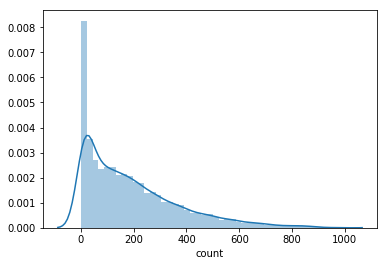

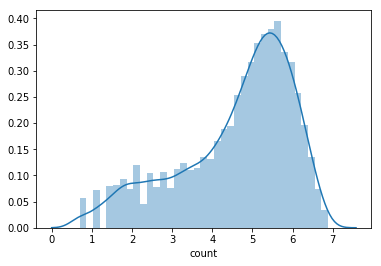

In [4]:
labels =  train['count']
sns.distplot(labels)
plt.show()
labels = labels.apply(lambda x: np.log1p(x))
sns.distplot(labels)
plt.show()

# 2 特征工程

1 从上述分析，['season','holiday','workingday','weather',] 应该被处理成categorical   
2 需要从datetime中抽取出 'date', 'hour', 'weekday','month'等特征   
3 移除datetime

##  2.1 从datetime中抽取出 

In [5]:
dailyData = train

In [6]:
import calendar 
from datetime import datetime

dailyData= train
# dailyData['datetime'] = dailyData.datetime.apply(lambda x: x.date)
dailyData.datetime =  dailyData.datetime.apply(pd.to_datetime)
dailyData['month'] = dailyData.datetime.apply(lambda x: x.month)
dailyData['hour'] = dailyData.datetime.apply(lambda x:x.hour)
dailyData['year'] = dailyData.datetime.apply(lambda x:x.year)
dailyData['weekday'] =  dailyData.datetime.apply(lambda x: x.weekday())

In [7]:
dailyData.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,year,weekday
0,2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,2011,5


In [8]:
numericalFeatureNames = ["temp","humidity","atemp"]
dropFeatures = ['casual',"count","datetime","registered","windspeed"]
categryVariable = ['season', 'holiday',"workingday","weather","month","hour","weekday"]

In [9]:
for category in categryVariable:
    dummy = pd.get_dummies(dailyData[category], prefix=category)
    dailyData  = dailyData.join(dummy)
dailyData.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,...,0,0,0,0,0,0,0,0,1,0


In [10]:
dailyData= dailyData.drop(categryVariable, axis=1)
dailyData.head(1)

,datetime,temp,atemp,humidity,windspeed,casual,registered,count,year,season_1,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01,9.84,14.395,81,0.0,3,13,16,2011,1,...,0,0,0,0,0,0,0,0,1,0


In [11]:
dailyData = dailyData.drop(dropFeatures, axis=1)
# dailyData.dtypes

In [12]:
dailyData.columns

Index(['temp', 'atemp', 'humidity', 'year', 'season_1', 'season_2', 'season_3',
       'season_4', 'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

# 3 模型训练

## 3.1 定义代价函数
评价指标
$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

lg1p 与 expm1 是一对相反操作
 
log1p := log(x+1) 即ln(x+1)
expm1 := exp(x)-1

In [13]:
# 定义代价函数
def rmsle(y, y_):
    y =  np.expm1(y)
    y_ =  np.expm1(y_)
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    cal = np.square(log1 - log2)
    return np.sqrt(np.mean(cal))


## 3.2 分割训练集测试集

In [14]:
from sklearn.model_selection import train_test_split

train_data,test_data, train_labels,test_labels = train_test_split(dailyData, labels,test_size=0.235, random_state=42)

In [15]:
train_data.shape, test_data.shape

((8327, 59), (2559, 59))

## 3.3 线性回归模型


In [18]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# import warnings
# pd.options.mode.chained_assignment = None
# warnings.filterwarnings("ignore", category=DeprecationWarning)
liner_model = LinearRegression()
liner_model.fit(train_data, train_labels)
preds = liner_model.predict(test_data)
print('rmsle liner regression:', rmsle(test_labels, preds))

rmsle liner regression: 0.5756022067108384


## 3.2 正则化model 岭回归

{'alpha': 1, 'max_iter': 3000}
rmsle : ridge regression:  0.5757099138352254


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

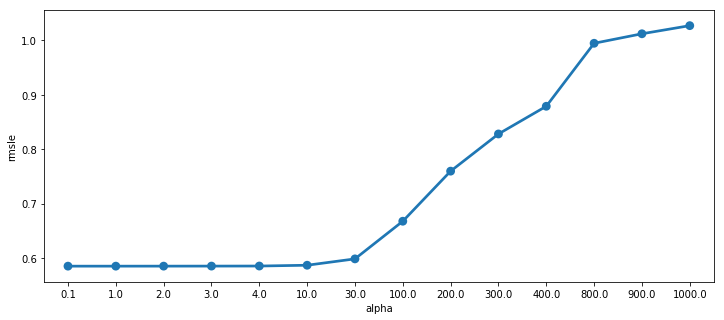

In [22]:
import matplotlib.pyplot as plt

from sklearn import metrics

from sklearn.model_selection import GridSearchCV
ridge_model = Ridge()
ridge_params = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_model,
                          ridge_params,
                          scoring = rmsle_scorer,
                          cv=5)

grid_ridge_m.fit(train_data, train_labels)
preds = grid_ridge_m.predict(test_data)
print (grid_ridge_m.best_params_)
print ("rmsle : ridge regression: ",rmsle(test_labels, preds))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df, x="alpha", y="rmsle", ax=ax)

In [23]:
ridge = Ridge(alpha= 1, max_iter=3000)
ridge.fit(train_data, train_labels)
preds = ridge.predict(test_data)
print ("RMSLE Value For Ridge Regression: ",rmsle(test_labels, preds))


RMSLE Value For Ridge Regression:  0.5757099138352254


## 3.3 LASSO

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

{'alpha': 0.0002, 'max_iter': 200}
RMSLE Value For Lasso Regression:  0.5758179321753655


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

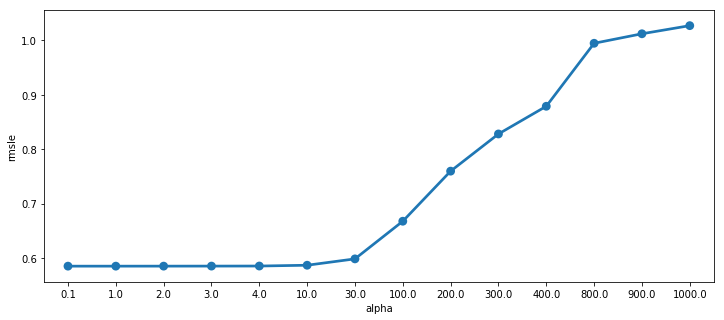

In [28]:
lasso_m_ = Lasso()

alpha  = 1/np.array([800,900,1000, 2000, 3000, 5000])
lasso_params_ = { 'max_iter':[100, 200, 300],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,
                            lasso_params_,
                            scoring = rmsle_scorer,
                            cv=5)
# yLabelsLog = np.log1p(train_labels)
grid_lasso_m.fit( train_data, train_labels )
preds = grid_lasso_m.predict(X= test_data)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(test_labels, preds))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df, x="alpha", y="rmsle", ax=ax)

In [29]:
lasso = Lasso(alpha=0.0002, max_iter=200)
lasso.fit(train_data, train_labels)
preds = lasso.predict(test_data)
print ("RMSLE Value For Lasso Regression: ",rmsle(test_labels, preds))


RMSLE Value For Lasso Regression:  0.5758179321753655


## 3.4 ElasticNet

In [30]:
from sklearn.linear_model import ElasticNet

ENet = ElasticNet(alpha=0.001, l1_ratio=0.8, random_state=3)
ENet.fit( train_data, train_labels )
preds =  ENet.predict(test_data)
print ("RMSLE Value For Elastic NEt Regression: ",rmsle(test_labels, preds))



RMSLE Value For Elastic NEt Regression:  0.5775568891667752


# 4 模型融合
## 4.1 random forest

{'n_estimators': 400, 'min_samples_leaf': 2}
RMSLE Value For Random Forest Regression:  0.3238356805156599


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

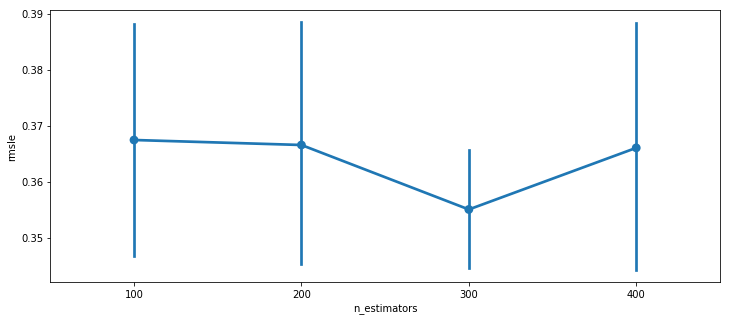

In [39]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    "n_estimators": [100, 200, 300, 400],
    "min_samples_leaf": [2, 4, 6]
}
    
rf_model = RandomForestRegressor()
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# grid_rf = GridSearchCV(rf_model, 
#                        param_grid=rf_params,  
#                        scoring=rmsle_scorer, 
#                        cv = 5)

grid_rf = RandomizedSearchCV(rf_model, 
                            param_distributions=rf_params, 
                            scoring=rmsle_scorer, 
                            cv = 5)
grid_rf.fit(train_data, train_labels)

preds =  grid_rf.predict(test_data)
print (grid_rf.best_params_)
print ("RMSLE Value For Random Forest Regression: ",rmsle(test_labels, preds))


fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_rf.cv_results_)

df["n_estimators"] = df["params"].apply(lambda x:x["n_estimators"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df, x="n_estimators", y="rmsle", ax=ax)


# for n_estimator in  [100, 200, 300,400,500]:
    
# rfModel =  RandomForestRegressor(n_estimators= 400)
# rfModel.fit(train_data,train_labels)
# preds = rfModel.predict(X= test_data)
# print ("RMSLE Value For Random Forest: ",rmsle(test_labels, preds))

In [41]:
rf_model = RandomForestRegressor(n_estimators=400)
rf_model.fit(train_data, train_labels)
preds = rf_model.predict(test_data)
print ("RMSLE Value For Random Forest: ",rmsle(test_labels, preds))

RMSLE Value For Random Forest:  0.3212005464045944


## 4.2 GBDT 

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=2000,alpha=0.01,learning_rate=0.1, max_depth=4); ### Test 0.41
# yLabelsLog = np.log1p(yLabels)
gbm.fit(train_data,train_labels)
preds = gbm.predict(X= test_data)
print ("RMSLE Value For Gradient Boost: ",rmsle(test_labels, preds))

RMSLE Value For Gradient Boost:  0.2976687324590541


## 4.3 XGBoost

In [44]:

from  xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.1, 
                   n_estimators=1200, 
                   max_depth=4, 
                   gamma=0, 
                   subsample=0.8)

xgb.fit(train_data, train_labels)
preds = xgb.predict(test_data)
print("RMSLE Value For XGB Boost: ", rmsle(test_labels, preds))


ModuleNotFoundError: No module named 'xgboost'

## 4.4 LoghtGBM

In [45]:
import lightgbm as lgb
from sklearn.grid_search import GridSearchCV

# 使用超参数搜索
parameters_space =[{
    'learning_rate':[0.05, 0.1,0.15,],
    'n_estimators':[ 2500 ,3000,3500],
}]




lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.3, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
clf = GridSearchCV(lgb_model, param_grid= parameters_space, cv=5)
clf.fit(train_data, train_labels)
print(clf.grid_scores_)
print(clf.best_params_)


# lgb_model.fit(train_data, train_labels)
# preds = lgb_model.predict(test_data)

# print("RMSLE Value For lightGBM models :", rmsle(preds, test_labels))

ModuleNotFoundError: No module named 'lightgbm'

In [63]:
# 使用上面超参数搜索的最优参数
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.1, n_estimators=3500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(train_data, train_labels)
preds = lgb_model.predict(test_data)

print("RMSLE Value For lightGBM models :", rmsle(preds, test_labels))

RMSLE Value For lightGBM models : 0.2910853505270705


## 4.5 多模型效果 Stacking
### 4.5.1 多模型平均

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [66]:
# 5种模型融合
average_models1 = AveragingModels(models=(ENet, lasso, ridge,gbm, rfModel))
average_models1.fit(train_data, train_labels)
preds = average_models1.predict(test_data)

print("RMSLE Value For average models(stacking) : ", rmsle(test_labels, preds))

RMSLE Value For average models(stacking) :  0.4187658633866439


5种模型平均：效果一般 0.418

In [67]:
# 使用效果最好的XGboost 和GBR融合
average_models2 = AveragingModels(models=(gbm, xgb))
average_models2.fit(train_data, train_labels)
preds = average_models2.predict(test_data)

print("RMSLE Value For average models(stacking) : ", rmsle(test_labels, preds))

RMSLE Value For average models(stacking) :  0.29112142032363675


初步融合结果0.291，可以看到比单模型的0.297 和0.293 要好一些

In [68]:
# 3种模型融合 XGBoost GBR RandomForest
average_models3 = AveragingModels(models=(gbm, rfModel, xgb))
average_models3.fit(train_data, train_labels)
preds = average_models3.predict(test_data)

print("RMSLE Value For average models(stacking: gbm+rf+xgb) : ", rmsle(test_labels, preds))

RMSLE Value For average models(stacking: gbm+rf+xgb) :  0.2873859940043319


效果更好：0.286

In [69]:
# 3种模型融合 XGBoost GBR lghtGBM 
average_models4 = AveragingModels(models=(gbm, lgb_model, xgb))
average_models4.fit(train_data, train_labels)
preds = average_models4.predict(test_data)

print("RMSLE Value For average models(stacking: gbm+rf+xgb) : ", rmsle(test_labels, preds))

RMSLE Value For average models(stacking: gbm+rf+xgb) :  0.28655998890245626


效果还可以：0.286

使用4中模型试试

In [70]:
# 4 种模型融合 XGBoost GBR lghtGBM  rf
average_models5 = AveragingModels(models=(gbm, lgb_model, xgb, rfModel))
average_models5.fit(train_data, train_labels)
preds = average_models5.predict(test_data)

print("RMSLE Value For average models(stacking: ) : ", rmsle(test_labels, preds))

RMSLE Value For average models(stacking: ) :  0.2840777514023266


### 4.5.2 使用元模型

In [48]:
# from sklearn.model_selection import KFold
# class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds
   
#     # We again fit the data on clones of the original models
#     def fit(self, X, y):
#         self.base_models_ = [list() for x in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
#         # Train cloned base models then create out-of-fold predictions
#         # that are needed to train the cloned meta-model
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index], y[train_index])
#                 y_pred = instance.predict(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred
                
#         # Now train the cloned  meta-model using the out-of-fold predictions as new feature
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self
   
#     #Do the predictions of all base models on the test data and use the averaged predictions as 
#     #meta-features for the final prediction which is done by the meta-model
#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

In [50]:
# stacked_averaged_models = StackingAveragedModels(base_models = (ENet, gbm, rfModel, ridge),
#                                                  meta_model = lasso)

# stacked_averaged_models.fit(train_data, train_labels)
# preds = stacked_averaged_models.predict(test_data)
# print("Stacking Averaged models score", rmsle(test_labels, preds))


# 5 输出结果
## 5.1 按照训练数据格式处理测试数据

In [71]:
real_test_data = pd.read_csv('../input/test.csv')
real_test_data_ids = real_test_data["datetime"]
real_test_data.head(3)

real_test_data.datetime =  real_test_data.datetime.apply(pd.to_datetime)
real_test_data['month'] = real_test_data.datetime.apply(lambda x: x.month)
real_test_data['hour'] = real_test_data.datetime.apply(lambda x:x.hour)
real_test_data['year'] = real_test_data.datetime.apply(lambda x:x.year)
real_test_data['weekday'] =  real_test_data.datetime.apply(lambda x: x.weekday())

# real_test_data.head()

numericalFeatureNames = ["temp","humidity","atemp"]

dropFeatures = ["datetime","windspeed"]

categryVariable = ['season', 'holiday',"workingday","weather","month","hour","weekday"]

for category in categryVariable:
    dummy = pd.get_dummies(real_test_data[category], prefix=category)
    real_test_data  = real_test_data.join(dummy)

real_test_data= real_test_data.drop(categryVariable, axis=1)
real_test_data = real_test_data.drop(dropFeatures, axis=1)

In [72]:
real_test_data.columns

Index(['temp', 'atemp', 'humidity', 'year', 'season_1', 'season_2', 'season_3',
       'season_4', 'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

## 5.2 预测数据、保存结果

In [73]:
# 使用效果最好的stcking模型 average_model5 进行预测
real_test_prediction = average_models5.predict(real_test_data)
real_test_prediction = np.expm1(real_test_prediction)

In [74]:
submission = pd.DataFrame({
        "datetime": real_test_data_ids,
        "count": [max(0, x) for x in real_test_prediction]
    })
submission.head()

,count,datetime
0,10.851295,2011-01-20 00:00:00
1,3.482689,2011-01-20 01:00:00
2,3.106510,2011-01-20 02:00:00
3,2.383235,2011-01-20 03:00:00
4,1.423621,2011-01-20 04:00:00


In [75]:
submission.to_csv('../result/stacking.csv', index= False)

# 最终分数0.40063，大概在233/3251 值得注意的是，在将label log1p之前，分数只有0.49， 通过将y值label平滑处理，可以很大程序提高预测准确度
# 参数调优部分可以使用GridSearch 再试试，尤其是 GBM和RF两部分的参数调优，可以再试试看能不能达到更好的效果
# 接下来可以使用 XGboost试试


# 总结


特征工程部分，参考了kaggle上的部分kernel，主要技巧是：  
1 抽取时间特征并one-hot编码（pd.get_dummies）
2 分析特征之间的相关性，去除不必要特征
3 需要对label标签平滑处理，可以画出label的变化曲线，分析是否平滑，这一步将分数从0.49提高到0.40，直接进入top 10（233位）

接下来：

1  使用GridSearch 尝试RandomForest 和GBR 的参数调优，看看能不能达到更好的结果
2  尝试使用XGBoost

https://www.kaggle.com/valeriyparubets/sklearn-gbr-0-413/code GridSearchCV

```

更新：使用融合模型  average_models5 后，最终的分数在0.38406 排到135位

# 最终分数0.40063，大概在233/3251 值得注意的是，在将label log1p之前，分数只有0.49， 通过将y值label平滑处理，可以很大程序提高预测准确度
# 参数调优部分可以使用GridSearch 再试试，尤其是 GBM和RF两部分的参数调优，可以再试试看能不能达到更好的效果
# 接下来可以使用 XGboost试试

```